# Appendix E: Support Vector Machine Regression

Another technique used to model our data was SVR, which uses support vector machines to fit a regression model to the data. This method has numerous advantages, such as its general applicability and ease of customisation, though it struggles to deal with large volumes of data.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

The data is read into python from a single .csv file containing all of the Victorian data from 2000 to 2020. Only data from 2015 to 2020 is used for analysis.

In [2]:
#%% Reading data
VIC_data = pd.read_csv('VIC_Data_Compiled.csv')
VIC_data.set_index(pd.to_datetime(VIC_data.date), inplace=True)
start = pd.Timestamp("2015-01-01 00:00:00")
end = pd.Timestamp("2020-01-01 00:00:00")
VIC_data = VIC_data[start:end]
VIC_data_full = VIC_data

y = VIC_data_full.iloc[:, 1].values
X = VIC_data_full.iloc[:, 3].values

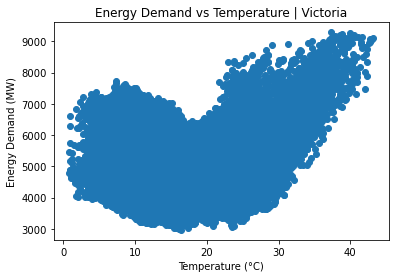

In [3]:
plt.scatter(x = X, y = y)
plt.title("Energy Demand vs Temperature | Victoria")
plt.xlabel("Temperature (°C)")
plt.ylabel("Energy Demand (MW)")
plt.show()

In [4]:
#sns.lineplot(x=VIC_data_full.date, y=VIC_data_full.TEMP)

As stated above, one of the disadvantages of SVR modelling is its computational cost. Once datasets exceed ~10,000 observations SVR struggles to produce a model in a reasonable timeframe. For this reason, a random sample of 10,000 datapoints are taken from the data, with the independent variable being the temperature measurements and the response variable being the corresponding energy demand.

In [5]:
#%% Sampling
VIC_data = VIC_data.sample(n=10000, random_state=30632358)

y = VIC_data.iloc[:, 1].values
X = VIC_data.iloc[:, 3].values
X_raw = np.array(X).reshape(-1,1)
y_raw = np.array(y).reshape(-1,1)

The data is normalised to ensure accurate modelling, without the differing magnitudes of the variables skewing the model. An 80/20 train-test split is performed on the data before it is modelled.

In [6]:
#%% Normalisation
X = (X_raw-np.mean(X_raw))/np.std(X_raw)
y = (y_raw-np.mean(y_raw))/np.std(y_raw)

In [7]:
#%% T-T Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1) 

The model is initialised with a cubic polynomial kernel with optimal hyperparameters given from cross validation performed below. The model is then used to fit a prediction to the testing data.

In [8]:
#%% Model fitting
from sklearn.svm import SVR

#regressor = SVR(kernel="sigmoid", C=1, gamma=1, epsilon=1) #RBF
regressor = SVR(kernel="poly", C=0.1, gamma=0.1, degree=3, epsilon=1, coef0 = 10) #POLY

regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

y_pred = regressor.predict(X_test).reshape(-1,1)

coeffs = np.polyfit(x = X_test.ravel().tolist(), y = y_pred.ravel().tolist(), deg = 2) #POLY

Shown below is a graph which overlays the model onto the true data.

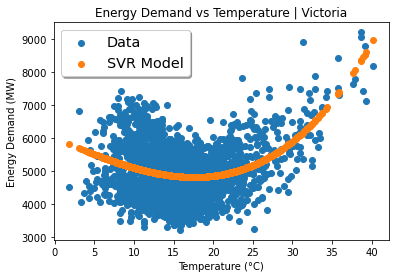

In [9]:
#%% Plotting model
X_plot = X_test * np.std(X_raw) + np.mean(X_raw)
y_plot = y_test * np.std(y_raw) + np.mean(y_raw)
y_pred_plot = y_pred * np.std(y_raw) + np.mean(y_raw)

plt.scatter(x = X_plot, y = y_plot, label = "Data")
plt.scatter(x = X_plot, y = y_pred_plot, label = "SVR Model")
plt.title("Energy Demand vs Temperature | Victoria")
plt.xlabel("Temperature (°C)")
plt.ylabel("Energy Demand (MW)")
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.show()

The model's error metrics and goodness of fit are calculated and presented below. Due to the volume of data and high variability in the y variable, these metrics show that the model is generally a good fit to the data. While the goodness of fit appears low at first glance, it is inevitable that only general trends will be accurately modelled on this dataset.

In [10]:
#%% Error Metrics
y_pred = y_pred * np.std(y_raw) + np.mean(y_raw)
y_test = y_test * np.std(y_raw) + np.mean(y_raw)

from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
print(f"Root Mean Square Error: {RMSE:.4f}")

from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {MAE:.4f}")

from sklearn.metrics import r2_score
R2 = r2_score(y_test, y_pred)
print(f"R2: {R2:.4f}")

Root Mean Square Error: 791.4599
Mean Absolute Error: 656.4512
R2: 0.1812


A grid search cross-validation was undertaken to find the optimal hyperparameters for the model. Due to the computation time required to run this algorithm, it is left commented out below. The model fit above uses these optimal hyperparameters.

In [11]:
#%% Cross Validations
#This takes like 2h to run
# from sklearn.model_selection import GridSearchCV

# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [0.1,0.01,0.001],'kernel': ['poly'],'degree': [3], 'coef0': [0.01,0.1,1,10], 'epsilon': [1,0.1,0.01]} #POLY
# #param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf'], 'epsilon': [1,0.1,0.01]} #RBF

# grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=2)
# grid.fit(X_train,y_train)
# print(grid.best_estimator_) 

#POLY DEGREE 3
#BEST C: 0.1
#BEST coef0: 10
#BEST gamma: 0.1
#BEST epsilon: 1


Finally, we used the model we obtained to simulate the effect of climate change on the energy demand in Victoria in the future. For a predicted 3.1 degree increase/decrease in the extreme temperatures of Winter and Summer, our model predicts a 4.481% increase in total annual energy demand due to more extreme temperatures.

In [14]:
#%% Global Warming Forecasting
start = pd.Timestamp("2019-01-01 00:00:00")
end = pd.Timestamp("2020-01-01 00:00:00")
orig_2019 = VIC_data_full[start:end]
X_2019 = orig_2019.TEMP
y_2019 = orig_2019.DEMAND

total_demand_2019 = y_2019.sum()

offset = 2
warmed_2019 = orig_2019.copy()
warmed_2019.TEMP += offset


X_warmed = np.array(warmed_2019.TEMP).reshape(-1,1)
X_warmed = (X_warmed-np.mean(X_raw)) / np.std(X_raw)

y_pred_warmed = regressor.predict(X_warmed)
y_pred_warmed = y_pred_warmed * np.std(y_raw) + np.mean(y_raw)
total_demand_warmed = y_pred_warmed.sum()
print(f"Predicted increase in energy demand: {((total_demand_warmed / total_demand_2019)-1)*100:.3f}%")

Predicted increase in energy demand: 2.464%
